In [1]:
# Amortized Empirical Bayes Matrix Factorization
# Author: William Denault

import torch
import torch.nn as nn
import torch.distributions as dist

# Simulate low-rank matrix Y = U V^T + noise
n, p, k = 100, 80, 5  # users, items, latent dim
true_U = torch.randn(n, k)
true_V = torch.randn(p, k)
Y = true_U @ true_V.T + 0.1 * torch.randn(n, p)
sigma = 0.1

# Define amortized inference networks
class RowEncoder(nn.Module):
    def __init__(self, p, k):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(p, 128), nn.ReLU(),
            nn.Linear(128, 2 * k)
        )

    def forward(self, y_row):
        out = self.net(y_row)
        mu, log_std = out[:, :k], out[:, k:]
        return mu, torch.exp(log_std)

class ColEncoder(nn.Module):
    def __init__(self, n, k):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n, 128), nn.ReLU(),
            nn.Linear(128, 2 * k)
        )

    def forward(self, y_col):
        out = self.net(y_col)
        mu, log_std = out[:, :k], out[:, k:]
        return mu, torch.exp(log_std)

# Initialize networks
row_encoder = RowEncoder(p, k)
col_encoder = ColEncoder(n, k)
log_tau_u = nn.Parameter(torch.tensor(0.0))
log_tau_v = nn.Parameter(torch.tensor(0.0))

params = list(row_encoder.parameters()) + list(col_encoder.parameters()) + [log_tau_u, log_tau_v]
optimizer = torch.optim.Adam(params, lr=1e-3)

# Training loop
for epoch in range(10000):
    optimizer.zero_grad()

    # Encode all rows and columns
    mu_u, std_u = row_encoder(Y)
    mu_v, std_v = col_encoder(Y.T)

    q_u = dist.Normal(mu_u, std_u)
    q_v = dist.Normal(mu_v, std_v)

    u_sample = q_u.rsample()
    v_sample = q_v.rsample()

    # Reconstruct Y
    Y_pred = u_sample @ v_sample.T
    log_lik = dist.Normal(Y_pred, sigma).log_prob(Y).sum()

    # KL terms
    p_u = dist.Normal(0, torch.exp(log_tau_u))
    p_v = dist.Normal(0, torch.exp(log_tau_v))
    kl_u = dist.kl_divergence(q_u, p_u).sum()
    kl_v = dist.kl_divergence(q_v, p_v).sum()

    elbo = log_lik - kl_u - kl_v
    loss = -elbo
    loss.backward()
    optimizer.step()

    if epoch % 500 == 0:
        print(f"Epoch {epoch}: ELBO={elbo.item():.2f}, KL_u={kl_u.item():.2f}, KL_v={kl_v.item():.2f}")

# Final latent embeddings
with torch.no_grad():
    U_mean, _ = row_encoder(Y)
    V_mean, _ = col_encoder(Y.T)
    print("\nInferred U shape:", U_mean.shape)
    print("Inferred V shape:", V_mean.shape)
    print("Prior tau_u:", torch.exp(log_tau_u).item())
    print("Prior tau_v:", torch.exp(log_tau_v).item())


Epoch 0: ELBO=-12058125.00, KL_u=277.75, KL_v=356.76
Epoch 500: ELBO=-7147.25, KL_u=2187.94, KL_v=1797.34
Epoch 1000: ELBO=-1556.52, KL_u=2611.19, KL_v=2144.22
Epoch 1500: ELBO=63.08, KL_u=2811.03, KL_v=2295.05
Epoch 2000: ELBO=758.71, KL_u=2903.76, KL_v=2368.75
Epoch 2500: ELBO=893.06, KL_u=2940.03, KL_v=2401.83
Epoch 3000: ELBO=1068.40, KL_u=2941.70, KL_v=2409.32
Epoch 3500: ELBO=1003.27, KL_u=2925.17, KL_v=2404.13
Epoch 4000: ELBO=1112.32, KL_u=2908.83, KL_v=2392.20
Epoch 4500: ELBO=1189.68, KL_u=2888.15, KL_v=2378.78
Epoch 5000: ELBO=1127.48, KL_u=2863.44, KL_v=2349.06
Epoch 5500: ELBO=978.71, KL_u=2848.98, KL_v=2341.95
Epoch 6000: ELBO=1139.96, KL_u=2823.73, KL_v=2309.74
Epoch 6500: ELBO=1325.84, KL_u=2782.34, KL_v=2293.77
Epoch 7000: ELBO=1281.86, KL_u=2737.81, KL_v=2269.11
Epoch 7500: ELBO=1499.76, KL_u=2680.30, KL_v=2241.12
Epoch 8000: ELBO=1627.40, KL_u=2611.66, KL_v=2214.93
Epoch 8500: ELBO=1700.82, KL_u=2560.10, KL_v=2180.06
Epoch 9000: ELBO=1875.79, KL_u=2462.97, KL_v=2141.

In [2]:
Y_final_pred = U_mean @ V_mean.T
final_rmse = torch.sqrt(((Y - Y_final_pred) ** 2).mean()).item()
final_rmse

0.10044094175100327

In [8]:
import sys
import os
import matplotlib.pyplot as plt

# Add the path to utils.py
sys.path.append(r"C:\Document\Serieux\Travail\python_work\cEBNM_torch\py")
sys.path.append(r"C:\Document\Serieux\Travail\python_work\cEBNM_torch\py\ebnm_solver")
sys.path.append(r"C:\Document\Serieux\Travail\python_work\cEBNM_torch\py\numerical_routine")
from cEBMF import *

In [9]:
Y_np = Y.detach().cpu().numpy()

mycebmf= cEBMF(data= Y_np)
mycebmf.init_LF()

In [10]:
for i in range(40):
    mycebmf.iter()

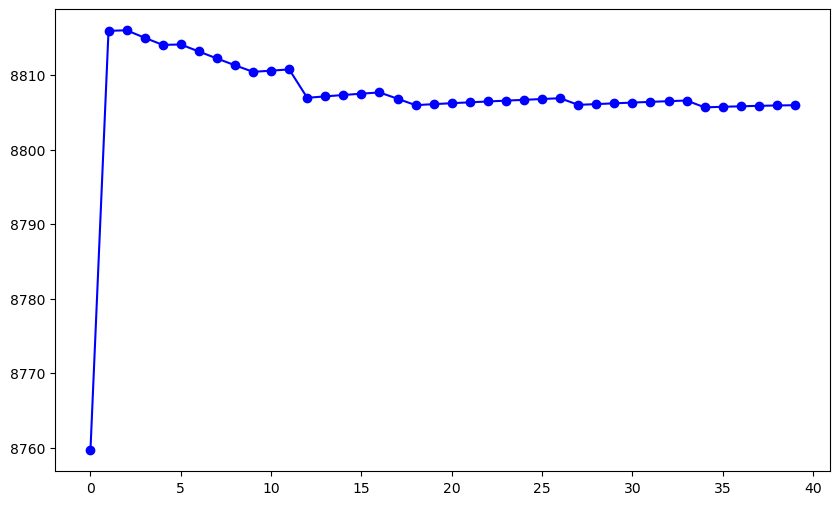

In [11]:
plt.figure(figsize=(10, 6))
plt.plot(np.array(mycebmf.obj)[1:], marker='o', linestyle='-', color='b')

In [13]:
np.sqrt(np.mean((Y_np - mycebmf.L @ mycebmf.F.T   ) ** 2))

0.09520877